#Using LoRA in Jax

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_using_LoRA.ipynb)


This tutorial demonstrates how to implement LoRA for efficient fine-tuning of language models in JAX.
It builds upon the [JAX for LLM pretraining](https://docs.jaxstack.ai/en/latest/JAX_for_LLM_pretraining.html) tutorial by showing how to replace standard linear
layers with LoRA-enabled linear layers to significantly reduce the number of trainable parameters.

LoRA (Low-Rank Adaptation) is a parameter-efficient fine-tuning technique that:
- Keeps pre-trained model weights frozen
- Adds small trainable low-rank decomposition matrices to certain layers
- Drastically reduces the number of trainable parameters (often by 90%+)

In the first chapter we will buildi a LoRA-enabled model from scratch, while the next chapter: "2. Fine-tuning a pre-trained LLM with LoRA" will demonstrate the more common and practical workflow of applying LoRA to existing pre-trained models.

Both chapters show how to implement these techniques using JAX and Flax's NNX library.

# 1.Creating a LoRa enabled LLM in Jax from scratch

In this chapter, we'll take an unconventional approach by implementing a language model with LoRA from scratch. This is different from standard practice, where LoRA is typically applied to already pre-trained models as a fine-tuning technique.

Why are we doing it this way? While not the optimal approach to train a model that achives good preformace (as we'll see in our results), building from scratch makes the integration of LoRA components within the model architecture more clear.

If you're interested in the more practical approach of applying LoRA to an existing pre-trained model, you can skip to the next chapter where we demonstrate that workflow.

## Setup
Install required packages

In [1]:
!pip install -q jax-ai-stack
!pip install -Uq tiktoken grain matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/99.7 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/424.2 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.2/424.2 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.9/394.9 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.5/433.5 kB 24.5 MB/s eta 

Confirm we have TPUs set up.

In [2]:
import jax
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

Get the [TinyStories dataset from Hugging Face](https://huggingface.co/datasets/roneneldan/TinyStories). We only use the training split.

In [3]:
!wget https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories-train.txt?download=true -O TinyStories-train.txt

--2025-03-22 10:21:26--  https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories-train.txt?download=true
Resolving huggingface.co (huggingface.co)... 18.172.134.24, 18.172.134.124, 18.172.134.4, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/42/7f/427f7497b6c6596c18b46d5a72e61364fcad12aa433c60a0dbd4d344477b9d81/c5cf5e22ff13614e830afbe61a99fbcbe8bcb7dd72252b989fa1117a368d401f?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27TinyStories-train.txt%3B+filename%3D%22TinyStories-train.txt%22%3B&response-content-type=text%2Fplain&Expires=1742642487&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MjY0MjQ4N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy80Mi83Zi80MjdmNzQ5N2I2YzY1OTZjMThiNDZkNWE3MmU2MTM2NGZjYWQxMmFhNDMzYzYwYTBkYmQ0ZDM0NDQ3N2I5ZDgxL2M1Y2Y1ZTIyZmYxMzYxNGU4MzBhZmJlNjFh

Import necessary libraries

In [4]:
import jax
import jax.numpy as jnp
import flax.nnx as nnx
from flax.nnx.nn.lora import LoRALinear  # Import LoRALinear
import optax
from dataclasses import dataclass
import grain.python as pygrain
from jax.experimental import mesh_utils
from jax.sharding import Mesh, PartitionSpec as P, NamedSharding
import pandas as pd
import tiktoken
import time

## Building the Model with LoRA

We'll use the same tokenizer and parallelism strategy as in the [pre-training tutorial](https://docs.jaxstack.ai/en/latest/JAX_for_LLM_pretraining.html).
The mesh defines how our computation will be distributed across TPU cores.

In [5]:
tokenizer = tiktoken.get_encoding("gpt2")
mesh = Mesh(mesh_utils.create_device_mesh((4, 2)), ('batch', 'model'))

The key difference from the original pre-training model is that we replace standard
`nnx.Linear` layers with `LoRALinear` layers from [Flax](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/nn/lora.html).


This way, only the small rank decomposition matrices need to be trained.

In [6]:
def causal_attention_mask(seq_len):
    return jnp.tril(jnp.ones((seq_len, seq_len)))

class TransformerBlock(nnx.Module):
    # update the __init__ function arguments to include lora_rank
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, *, rngs: nnx.Rngs, rate: float = 0.1, lora_rank=8):
        self.mha = nnx.MultiHeadAttention(num_heads=num_heads,
                                          in_features=embed_dim,
                                          kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), NamedSharding(mesh, P(None, 'model'))),
                                          bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                          rngs=rngs)
        self.dropout1 = nnx.Dropout(rate=rate)
        self.layer_norm1 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), NamedSharding(mesh, P('model'))),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P('model'))),
                                         rngs=rngs)
        # here we replace the regular linear layer with the LoRALinea layer
        self.linear1 = LoRALinear(
            in_features=embed_dim,
            out_features=ff_dim,
            lora_rank=lora_rank,  # set the rank for the low-rank matrices
            kernel_init=nnx.with_partitioning(nnx.initializers.normal(0.02), P('model', None)),
            bias_init=nnx.with_partitioning(nnx.initializers.zeros, None),
            rngs=rngs
        )
        # here we replace the regular linear layer with the LoRALinea layer
        self.linear2 = LoRALinear(
            in_features=ff_dim,
            out_features=embed_dim,
            lora_rank=lora_rank,
            kernel_init=nnx.with_partitioning(nnx.initializers.normal(0.02), P('model', None)),
            bias_init=nnx.with_partitioning(nnx.initializers.zeros, None),
            rngs=rngs
        )
        self.dropout2 = nnx.Dropout(rate=rate)
        self.layer_norm2 = nnx.LayerNorm(epsilon=1e-6,
                                         num_features=embed_dim,
                                         scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), NamedSharding(mesh, P(None, 'model'))),
                                         bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), NamedSharding(mesh, P(None, 'model'))),
                                         rngs=rngs)


    def __call__(self, inputs, training: bool = False):
        input_shape = inputs.shape
        _, seq_len, _ = input_shape
        mask = causal_attention_mask(seq_len)
        attention_output = self.mha(
            inputs_q=inputs,
            mask=mask,
            decode=False
        )
        attention_output = self.dropout1(attention_output, deterministic=not training)
        out1 = self.layer_norm1(inputs + attention_output)
        # feed-forward network with LoRA layer
        ffn_output = self.linear1(out1)
        ffn_output = nnx.relu(ffn_output)
        ffn_output = self.linear2(ffn_output)
        ffn_output = self.dropout2(ffn_output, deterministic=not training)

        return self.layer_norm2(out1 + ffn_output)


class TokenAndPositionEmbedding(nnx.Module):

    def __init__(self, maxlen: int, vocab_size: int, embed_dim: int, *, rngs: nnx.Rngs):
        self.token_emb = nnx.Embed(num_embeddings=vocab_size, features=embed_dim, rngs=rngs)
        self.pos_emb = nnx.Embed(num_embeddings=maxlen, features=embed_dim, rngs=rngs)

    def __call__(self, x):
        positions = jnp.arange(0, x.shape[1])[None, :]
        position_embedding = self.pos_emb(positions)
        token_embedding = self.token_emb(x)
        return token_embedding + position_embedding


class MiniGPT(nnx.Module):
    # update the __init__ function arguments to include lora_rank
    def __init__(self, maxlen: int, vocab_size: int, embed_dim: int, num_heads: int, feed_forward_dim: int, num_transformer_blocks: int, rngs: nnx.Rngs, lora_rank=8):
        self.embedding_layer = TokenAndPositionEmbedding(
                    maxlen, vocab_size, embed_dim, rngs=rngs
                )
        # create transformer blocks with LoRA
        self.transformer_blocks = [TransformerBlock(
            embed_dim, num_heads, feed_forward_dim, rngs=rngs, lora_rank=lora_rank
        ) for _ in range(num_transformer_blocks)]

        # modify the output layer to use LoRALinear instead of regular linear layer
        self.output_layer = LoRALinear(
            in_features=embed_dim,
            out_features=vocab_size,
            lora_rank=lora_rank,
            kernel_init=nnx.with_partitioning(nnx.initializers.normal(0.02), P('model', None)),
            bias_init=nnx.with_partitioning(nnx.initializers.zeros, None),
            rngs=rngs
        )


    def __call__(self, inputs, training: bool = False):
        x = self.embedding_layer(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        outputs = self.output_layer(x)
        return outputs

    def generate_text(self, max_tokens: int, start_tokens: [int], top_k=10):
        def sample_from(logits):
            logits, indices = jax.lax.top_k(logits, k=top_k)
            logits = nnx.softmax(logits)
            return jax.random.choice(jax.random.PRNGKey(0), indices, p=logits)

        def generate_step(start_tokens):
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = jnp.array(start_tokens[:maxlen])
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = jnp.array(start_tokens + [0] * pad_len)
            else:
                x = jnp.array(start_tokens)

            x = x[None, :]
            logits = self(x)
            next_token = sample_from(logits[0][sample_index])
            return next_token

        generated = []
        for _ in range(max_tokens):
            next_token = generate_step(start_tokens + generated)
            if next_token == tokenizer.encode('<|endoftext|>', allowed_special={'<|endoftext|>'})[0]:
              break
            generated.append(int(next_token))
        return tokenizer.decode(start_tokens + generated)

# modify the function arguments to include lora_rank
def create_model(rngs, lora_rank=8):
    return MiniGPT(maxlen, vocab_size, embed_dim, num_heads, feed_forward_dim, num_transformer_blocks=4, rngs=rngs,
                   lora_rank=lora_rank)

## Set Hyperparameters

We'll use the same hyperparameters as in the [pre-training tutorial](https://docs.jaxstack.ai/en/latest/JAX_for_LLM_pretraining.html) for consistency.

In [25]:
vocab_size = tokenizer.n_vocab
num_transformer_blocks = 8
maxlen = 256
embed_dim = 256
num_heads = 8
feed_forward_dim = 256
batch_size = 256  # You can adjust batch size based on your TP
num_epochs = 1
lora_rank = 128 # A higher rank will capture more complex patterns in the LLM, and will also increase the number of trainable parameters

## Prepare data

Data loading and preprocessing remains the same as in the [pre-training tutorial](https://docs.jaxstack.ai/en/latest/JAX_for_LLM_pretraining.html).
We create a TextDataset class to handle tokenization and padding.

In [26]:
@dataclass
class TextDataset:
    data: list
    maxlen: int

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        encoding = tokenizer.encode(self.data[idx], allowed_special={'<|endoftext|>'})[:self.maxlen]  # Tokenize and truncate
        return encoding + [0] * (self.maxlen - len(encoding))  # Pad to maxlen

def load_and_preprocess_data(file_path, batch_size, maxlen):

    with open(file_path, 'r') as f:
      text = f.read()

    stories = text.split('<|endoftext|>')
    stories = [story+'<|endoftext|>' for story in stories if story.strip()]
    df = pd.DataFrame({'text': stories})
    data = df['text'].dropna().tolist()
    dataset = TextDataset(data, maxlen)

    sampler = pygrain.IndexSampler(
        len(dataset),
        shuffle=False,
        seed=42,
        shard_options=pygrain.NoSharding(),
        num_epochs=num_epochs,
    )

    dl = pygrain.DataLoader(
        data_source=dataset,
        sampler=sampler,
        operations=[pygrain.Batch(batch_size=batch_size, drop_remainder=True)],
    )

    return dl

text_dl = load_and_preprocess_data('TinyStories-train.txt', batch_size, maxlen)

## Train the model with LoRA

LoRA's efficiency lies in how we train only the small adapter matrices while keeping the rest of the model frozen. Let's look at how we implement this in JAX:

In [57]:
# Create the model with LoRA
lora_model = create_model(rngs=nnx.Rngs(0), lora_rank=lora_rank)
# Filter for LoRA parameters only (look for lora_a and lora_b in the parameter path)
lora_params = nnx.All(nnx.Param, nnx.PathContains('lora_a') or nnx.PathContains('lora_b'))
# Create optimizer to only update LoRA parameters
optimizer = nnx.Optimizer(lora_model, optax.adam(1e-3), wrt=lora_params)

 Using `nnx.All` create a mask that identifies only our LoRA parameters, looking for lora_a or lora_b in the parameter paths. Then we:

- Configure the optimizer to only update these selected parameters using the `wrt` argument
-Create a special `diff_state` that directs gradient computation to only flow to these parameters

Now we can use this `diff_state` when computing gradients in our training step:

In [28]:
def loss_fn(model, batch):
    logits = model(batch[0])
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch[1]).mean()
    return loss, logits

@nnx.jit
def train_step(model: MiniGPT, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    # Create differentiable state that only includes LoRA parameters
    diff_state = nnx.DiffState(0, lora_params)
    grad_fn = nnx.value_and_grad(loss_fn, argnums=diff_state, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, lables=batch[1])
    optimizer.update(grads)

In [29]:
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'),
)
rng = jax.random.PRNGKey(0)

start_prompt = "Once upon a time"
start_tokens = tokenizer.encode(start_prompt)[:maxlen]
generated_text = lora_model.generate_text(
    maxlen, start_tokens
)
print(f"Initial generated text:\n{generated_text}\n")


metrics_history = {
  'train_loss': [],
}

prep_target_batch = jax.vmap(lambda tokens: jnp.concatenate((tokens[1:], jnp.array([0]))))

step = 0
for epoch in range(num_epochs):
    start_time = time.time()
    for batch in text_dl:
        if len(batch) % len(jax.devices()) != 0:
          continue
        input_batch = jnp.array(jnp.array(batch).T)
        target_batch = prep_target_batch(input_batch)
        train_step(lora_model, optimizer, metrics, jax.device_put((input_batch, target_batch), NamedSharding(mesh, P('batch', None))))

        if (step + 1) % 200 == 0:
          for metric, value in metrics.compute().items():
              metrics_history[f'train_{metric}'].append(value)
          metrics.reset()

          elapsed_time = time.time() - start_time
          print(f"Step {step + 1}, Loss: {metrics_history['train_loss'][-1]}, Elapsed Time: {elapsed_time:.2f} seconds")
          start_time = time.time()

          generated_text = lora_model.generate_text(
              maxlen, start_tokens
          )
          print(f"Generated text:\n{generated_text}\n")
        step += 1

generated_text = lora_model.generate_text(
    maxlen, start_tokens
)
print(f"Final generated text:\n{generated_text}")

Initial generated text:
Once upon a time choiricity electronically src LaureinterpretHatis Aviation utilizing electronicallyis revealingis Lund353 stationary choiris Ho Ho showdown showdown choir Journalsis MM showdownerreddefault Kag allotted showdownis showdown choir不is Laure showdown Schiff MM KagisFig Aviation markupbysserredis revealing Laure hanging Needs exhausted showdown srcisis Aviationborgh disgis Crystal showdown showdown showdown bystand flippedis showdownisFiguggestsemberredis revealingis revealingADRA Laure hanging/** Aviation Needsisampions nonsatur Stamfordis Laure bystandis wink (£ showdown showdown nons Maul Laure (£ compos showdownampions nonsbyss crafts Rarityis lic busiest stationary markup electronically diedbyssbean electronicallyis dried showdown showdown showdownampions nonsisis exhausteddefault markup electronically Laure showdown electronically MM showdown nonsbyssis showdown showdown roller Maul compos roller Ghost electronically MMis showdown showdown elec

Visualize the training loss.

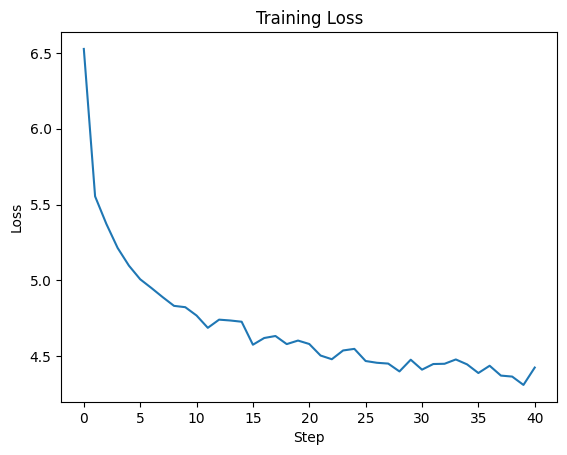

In [30]:
import matplotlib.pyplot as plt
plt.plot(metrics_history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [63]:
# Analysis of LoRA Parameter Efficiency using proper module iteration
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Initialize counters
total_params = 0
lora_a_params = 0
lora_b_params = 0
other_params = 0
layer_counts = {}

# Iterate through all modules and count parameters
for path, module in lora_model.iter_modules():
    module_name = '.'.join(str(p) for p in path) if path else "root"

    module_params = 0
    module_lora_params = 0

    for name, attr in vars(module).items():
        if name.startswith('_') or not hasattr(attr, 'value'):
            continue

        # Get the parameter array
        param_array = attr.value
        if not isinstance(param_array, jnp.ndarray):
            continue

        param_count = param_array.size
        module_params += param_count
        total_params += param_count

        # Check if this is a LoRA parameter
        if name == 'lora_a':
            lora_a_params += param_count
            module_lora_params += param_count
        elif name == 'lora_b':
            lora_b_params += param_count
            module_lora_params += param_count
        else:
            other_params += param_count

# Calculate total LoRA parameters and ratios
lora_params = lora_a_params + lora_b_params
trainable_ratio = lora_params / total_params
frozen_ratio = other_params / total_params

print(f"Total model parameters: {total_params:,}")
print(f"Frozen parameters: {other_params:,} ({frozen_ratio:.2%})")
print(f"Trainable LoRA parameters: {lora_params:,} ({trainable_ratio:.2%})")
print(f"  - LoRA A matrices: {lora_a_params:,}")
print(f"  - LoRA B matrices: {lora_b_params:,}")

Total model parameters: 34,420,433
Frozen parameters: 27,430,481 (79.69%)
Trainable LoRA parameters: 6,989,952 (20.31%)
  - LoRA A matrices: 294,912
  - LoRA B matrices: 6,695,040


This example has demonstrated the implementation of LoRA in JAX, showing how to replace standard linear layers with LoRA-enabled versions and train only these adapter parameters while keeping the base model frozen.

As we've seen from our experiment results, this approach of applying LoRA to a model trained from scratch produced limited generation quality. The text outputs were repetitive and lacked coherence.

That is because LoRA is designed to make incremental adaptations to already capable models, not to carry the full burden of learning language structure from scratch. The small parameter space of the LoRA matrices (even with rank=128) simply cannot capture the full complexity of language when starting from random initialization.


###Next Steps
In a subsequent chapter, we'll explore how to integrate LoRA into existing pre-trained language models rather than training from scratch. If you want to stop here and save your progress you can run the follwing cells:

### Saving

In [ ]:
import orbax.checkpoint as orbax

state = nnx.state(lora_model)

checkpointer = orbax.PyTreeCheckpointer()
checkpointer.save('/content/save', state)

# Make sure the files are there
!ls /content/save/

### Disconnect the Colab runtime

In [ ]:
from google.colab import runtime
runtime.unassign()

# 2. Fine-tuning a pre-trained LLM with LoRA